In [52]:
# 环境 & 设备检查
import torch
from ultralytics import YOLO

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
DEVICE = 0 if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [53]:
from pathlib import Path
import random
import shutil

import cv2
from PIL import Image
from tqdm import tqdm

ROOT = Path(".").resolve()

RAW_IMAGE_DIR = ROOT / "insert_images"
RAW_MASK_DIR = ROOT / "insert_masks"

IMAGE_DIR = ROOT / "images"
LABEL_DIR = ROOT / "labels"
DATASET_DIR = ROOT / "dataset"

IMAGE_DIR.mkdir(parents=True, exist_ok=True)
LABEL_DIR.mkdir(parents=True, exist_ok=True)

random.seed(42)  # 固定随机拆分，保证可复现

In [54]:
# 工具函数：数据准备


def convert_tif_folder_to_jpg(src_dir: Path, dst_dir: Path):
    """把 .tif 批量转 .jpg 放到 dst_dir。"""
    tif_files = sorted(src_dir.glob("*.tif"))
    print(f"在 {src_dir} 中找到 {len(tif_files)} 张 .tif 图片")

    for tif_path in tqdm(tif_files, desc="转换 .tif -> .jpg"):
        with Image.open(tif_path) as im:
            rgb_im = im.convert("RGB")
            out_path = dst_dir / f"{tif_path.stem}.jpg"
            rgb_im.save(out_path, "JPEG", quality=95)

    print("tif 转 jpg 完成\n")


def mask_tif_to_yolo_txt(mask_path: Path, txt_path: Path, class_id: int = 0):
    """把单张 mask 图（tif/png/gif）转成 YOLO 实例分割格式的 txt。"""
    img = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"读取失败: {mask_path}")

    if len(img.shape) == 2:
        gray = img  # (h, w)
    elif len(img.shape) == 3:
        if img.shape[2] == 4:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        else:
            img_bgr = img
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f"不支持的图像形状: {img.shape} 对应 {mask_path}")

    h, w = gray.shape
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(txt_path, "w", encoding="utf-8") as f:
        for cnt in contours:
            if len(cnt) < 6:
                continue  # 点太少的轮廓忽略
            coords = []
            for x, y in cnt.squeeze():
                coords.extend([f"{x / w:.6f}", f"{y / h:.6f}"])
            f.write(f"{class_id} {' '.join(coords)}\n")


def build_labels_from_masks(
    mask_dir: Path, label_dir: Path, class_id: int = 0, preview: int = 5
):
    """遍历 mask 目录并生成 YOLO seg 标签文件。"""
    label_dir.mkdir(parents=True, exist_ok=True)

    mask_files = []
    for ext in ["*.tif", "*.tiff", "*.png", "*.gif"]:
        mask_files.extend(mask_dir.glob(ext))
    mask_files = sorted(mask_files)
    print(f"在 {mask_dir} 中找到 {len(mask_files)} 张 mask 图像（tif/tiff/png/gif）")

    for mask_path in tqdm(mask_files, desc="Converting mask -> YOLO txt"):
        txt_path = label_dir / f"{mask_path.stem}.txt"
        mask_tif_to_yolo_txt(mask_path, txt_path, class_id=class_id)

    print(f"标签写入完成，共 {len(list(label_dir.glob('*.txt')))} 个\n")
    print("前几项标签内容预览：")
    for p in list(label_dir.glob("*.txt"))[:preview]:
        print(f"=== {p.name} ===")
        with open(p, "r", encoding="utf-8") as f:
            for i, line in enumerate(f.readlines()):
                print(line.strip())
                if i >= 1:
                    break


def split_dataset(
    images_dir: Path,
    labels_dir: Path,
    dataset_dir: Path,
    train_ratio: float = 0.9,
    val_ratio: float = 0.09,
):
    """按给定比例拆分 train/val/test，并复制图像+标签。"""
    all_images = sorted(images_dir.glob("*.jpg"))
    valid_images = [p for p in all_images if (labels_dir / f"{p.stem}.txt").exists()]

    print(f"共找到 {len(all_images)} 张 .jpg 图像，含标签的有 {len(valid_images)} 张")
    random.shuffle(valid_images)

    n_total = len(valid_images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val

    splits = {
        "train": valid_images[:n_train],
        "val": valid_images[n_train : n_train + n_val],
        "test": valid_images[n_train + n_val :],
    }

    for split_name, img_list in splits.items():
        img_out_dir = dataset_dir / split_name / "images"
        lbl_out_dir = dataset_dir / split_name / "labels"
        img_out_dir.mkdir(parents=True, exist_ok=True)
        lbl_out_dir.mkdir(parents=True, exist_ok=True)

        for img_path in img_list:
            lbl_path = labels_dir / f"{img_path.stem}.txt"
            shutil.copy(img_path, img_out_dir / img_path.name)
            shutil.copy(lbl_path, lbl_out_dir / lbl_path.name)

    for split_name in ["train", "val", "test"]:
        n_i = len(list((dataset_dir / split_name / "images").glob("*.jpg")))
        n_l = len(list((dataset_dir / split_name / "labels").glob("*.txt")))
        print(f"{split_name}: images={n_i}, labels={n_l}")


def write_data_yaml(dataset_dir: Path, out_path: Path, class_names):
    """写 YOLO 数据集配置文件。"""
    names_block = "\n".join([f"  {i}: {name}" for i, name in enumerate(class_names)])
    content = f"""path: {dataset_dir.as_posix()}
train: train/images
val: val/images
test: test/images

names:
{names_block}
"""
    out_path.write_text(content, encoding="utf-8")
    print("数据集配置已写入:", out_path)
    print("\n内容预览:\n")
    print(content)

In [55]:
# Step 1: 转换 insert_images/*.tif -> images/*.jpg
convert_tif_folder_to_jpg(RAW_IMAGE_DIR, IMAGE_DIR)

在 D:\unitec\yolo-segmentation-learning\insert_images 中找到 20 张 .tif 图片


转换 .tif -> .jpg: 100%|██████████| 20/20 [00:00<00:00, 127.81it/s]

tif 转 jpg 完成



In [56]:
# Step 2: mask -> YOLO 分割标签
build_labels_from_masks(RAW_MASK_DIR, LABEL_DIR, class_id=0)

在 D:\unitec\yolo-segmentation-learning\insert_masks 中找到 20 张 mask 图像（tif/tiff/png/gif）


Converting mask -> YOLO txt: 100%|██████████| 20/20 [00:00<00:00, 65.05it/s]

标签写入完成，共 20 个

前几项标签内容预览：
=== 21.txt ===
0 0.113274 0.686644 0.111504 0.688356 0.111504 0.693493 0.109735 0.695205 0.109735 0.698630 0.107965 0.700342 0.107965 0.702055 0.104425 0.705479 0.104425 0.707192 0.102655 0.708904 0.104425 0.708904 0.104425 0.707192 0.106195 0.705479 0.106195 0.703767 0.107965 0.702055 0.107965 0.700342 0.109735 0.698630 0.109735 0.695205 0.113274 0.691781 0.118584 0.696918 0.118584 0.698630 0.120354 0.700342 0.120354 0.703767 0.123894 0.707192 0.123894 0.708904 0.129204 0.714041 0.132743 0.714041 0.134513 0.715753 0.132743 0.714041 0.130973 0.714041 0.129204 0.712329 0.127434 0.712329 0.125664 0.710616 0.125664 0.708904 0.122124 0.705479 0.122124 0.703767 0.120354 0.702055 0.120354 0.700342 0.118584 0.698630 0.118584 0.696918 0.116814 0.695205 0.116814 0.693493 0.113274 0.690068
0 0.899115 0.645548 0.902655 0.645548 0.904425 0.647260 0.911504 0.647260 0.915044 0.650685 0.916814 0.650685 0.918584 0.652397 0.922124 0.652397 0.923894 0.654110 0.923894 0.655822 0

In [57]:
# Step 3: 划分 train/val/test 并拷贝到 dataset/
split_dataset(IMAGE_DIR, LABEL_DIR, DATASET_DIR, train_ratio=0.9, val_ratio=0.09)

共找到 20 张 .jpg 图像，含标签的有 20 张
train: images=20, labels=20
val: images=2, labels=2
test: images=2, labels=2


In [58]:
# Step 4: 写 data.yaml（后续训练/预测都用它）
DATA_YAML_PATH = ROOT / "rectus_femoris_seg.yaml"
write_data_yaml(DATASET_DIR, DATA_YAML_PATH, class_names=["rectus_femoris"])

数据集配置已写入: D:\unitec\yolo-segmentation-learning\rectus_femoris_seg.yaml

内容预览:

path: D:/unitec/yolo-segmentation-learning/dataset
train: train/images
val: val/images
test: test/images

names:
  0: rectus_femoris



In [59]:
# Step 5: 训练 YOLO 分割模型
model = YOLO("yolo11n-seg.pt")

results = model.train(
    data=str(DATA_YAML_PATH),
    imgsz=640,
    epochs=100,  # Demo 可先跑少量 epoch，后续可增大
    batch=4,
    workers=2,
    device=DEVICE,
)

print("训练完成！best.pt 等权重会保存在 runs/segment/train*/weights/ 下面。")

Ultralytics 8.3.235  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\unitec\yolo-segmentation-learning\rectus_femoris_seg.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

检测到最新 run： D:\unitec\yolo-segmentation-learning\runs\segment\train4
加载训练日志 CSV 文件： D:\unitec\yolo-segmentation-learning\runs\segment\train4\results.csv

CSV 列名：
['epoch', 'time', 'train/box_loss', 'train/seg_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)', 'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


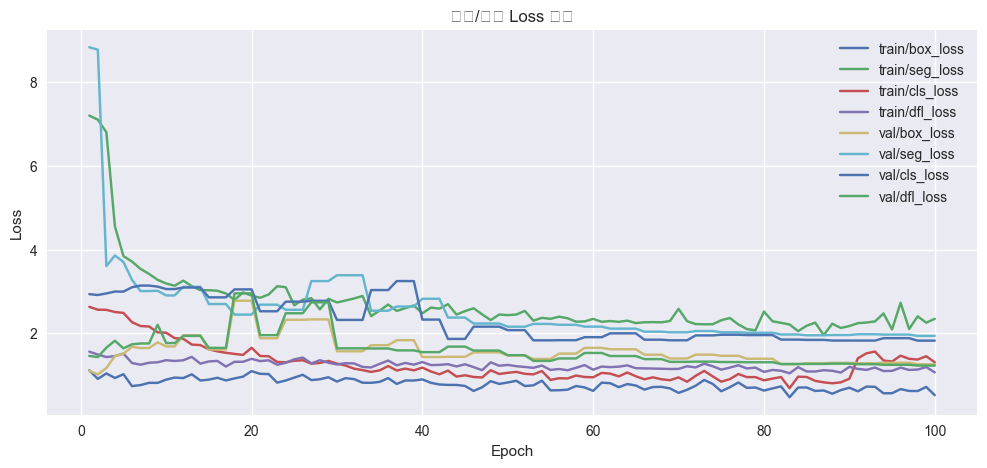

d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\rvs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


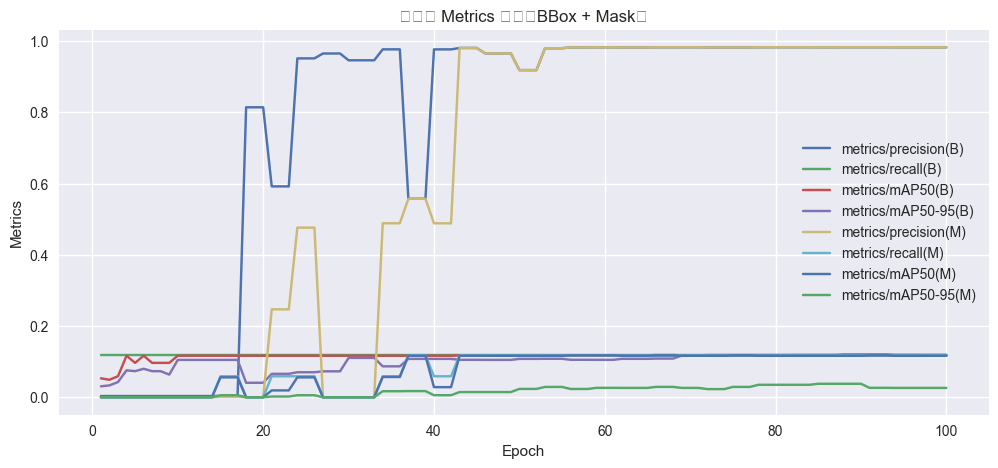

In [60]:
# Step 6: 可视化训练结果

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 推荐风格
plt.style.use("seaborn-v0_8")

# ---- 1. 找到最新训练 run ----
ROOT = Path(".").resolve()
runs_dir = ROOT / "runs" / "segment"

if not runs_dir.exists():
    raise FileNotFoundError("没有找到 runs/segment/ ，请先训练 YOLO。")

# 找到最新的 run 文件夹：train, train2, train3...
last_run = max(runs_dir.iterdir(), key=lambda p: p.stat().st_mtime)
print("检测到最新 run：", last_run)

csv_path = last_run / "results.csv"
print("加载训练日志 CSV 文件：", csv_path)

if not csv_path.exists():
    raise FileNotFoundError("results.csv 不存在，可能训练未正常结束。")

# ---- 2. 读取 CSV ----
df = pd.read_csv(csv_path)

print("\nCSV 列名：")
print(df.columns.tolist())

epochs = df["epoch"]

# ---- 3. 绘制 Loss 曲线 ----
loss_cols = [c for c in df.columns if "loss" in c]

if len(loss_cols) == 0:
    print("\n⚠️ 没有找到 loss 列，CSV 可能损坏或训练太短。")
else:
    plt.figure(figsize=(12, 5))
    for col in loss_cols:
        plt.plot(epochs, df[col], label=col)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("训练/验证 Loss 曲线")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---- 4. 绘制 Metrics 曲线 ----
metric_cols = [c for c in df.columns if c.startswith("metrics/")]

if len(metric_cols) == 0:
    print("\n⚠️ 没有找到 metrics 列，可能是 segmentation 数据集太小或训练太早期。")
else:
    plt.figure(figsize=(12, 5))
    for col in metric_cols:
        plt.plot(epochs, df[col], label=col)
    plt.xlabel("Epoch")
    plt.ylabel("Metrics")
    plt.title("验证集 Metrics 曲线（BBox + Mask）")
    plt.legend()
    plt.grid(True)
    plt.show()


使用权重: D:\unitec\yolo-segmentation-learning\runs\segment\train4\weights\best.pt
从测试集中选取 2 张图片做预测

0: 640x640 1 rectus_femoris, 9.7ms
1: 640x640 1 rectus_femoris, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


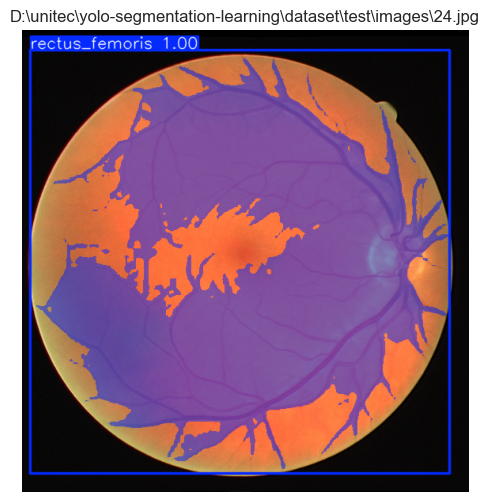

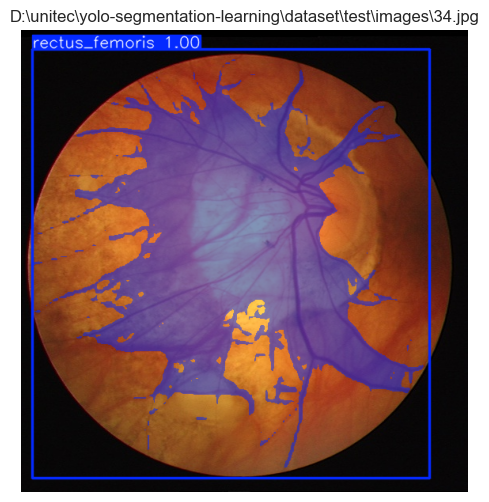

In [61]:
# Step 7: 载入最新权重做预测 & 可视化
import matplotlib.pyplot as plt

runs_dir = ROOT / "runs" / "segment"
if runs_dir.exists():
    last_run = max(runs_dir.iterdir(), key=lambda p: p.stat().st_mtime)
    best_ckpt = last_run / "weights" / "best.pt"
else:
    best_ckpt = ROOT / "runs" / "segment" / "train" / "weights" / "best.pt"  # 兜底路径

print("使用权重:", best_ckpt)

pred_model = YOLO(str(best_ckpt))

test_images_dir = DATASET_DIR / "test" / "images"
sample_images = list(test_images_dir.glob("*.jpg"))[:5]
print(f"从测试集中选取 {len(sample_images)} 张图片做预测")

if sample_images:
    results = pred_model.predict(
        source=[str(p) for p in sample_images],
        imgsz=640,
        conf=0.5,
        device=DEVICE,
    )

    for r in results:
        im_array = r.plot()  # 带 mask 的可视化图像（numpy array, BGR）
        im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 6))
        plt.imshow(im_rgb)
        plt.axis("off")
        plt.title(str(r.path))
        plt.show()
else:
    print("测试集中没有图片可预测，请先准备数据集")